# 5.2-Phenotyping Clonotypes from deepTCR seq

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-27"

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(scRepertoire)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(stringr)
library(cowplot)
}))

## Parameters

In [3]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_83_120/misc/paths.R"))
source(here("utils/bin.R"))
source(here("utils/style.R"))

set.seed(0)

In [4]:
# depending on clone call
mode = "nt" 
chain = "TRB"

In [5]:
cd8_clusters <- c("4", "5_0", "6", "9", "13", "14_1")
cd4_clusters <- c("0", "1", "2","3","5_1", "7", "8", "10", "12")
others <- c("11", "14_0", "15")

## Load data

Adding phenotype with 10x data to a selection of expanded clonotypes found with deep TCR


In [6]:
### Load 10x data

In [7]:
pbmc_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-pbmcTCR_{mode}_{chain}.rds")))
tumor_obj <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-tumorTCR_{mode}_{chain}.rds")))

In [8]:
pbmc_obj$Tcell_clusters <- factor(pbmc_obj$Tcell_clusters, levels=c(cd8_clusters, cd4_clusters, others))
pbmc_obj <- SetIdent(pbmc_obj, value=pbmc_obj@meta.data$Tcell_clusters)

### Load deep TCR

Load selected clonotypes from deepTCR sequencing

In [9]:
tcr_dn <- read_csv(here(glue("ext_data/de_novo_cdr3.csv")))
tcr_dn$deepTCR <- "de novo"
tcr_pre <- read_csv(here(glue("ext_data/pre_existing_cdr3.csv")))
tcr_pre$deepTCR <- "pre-existing"

Rows: 10 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): cdr3, ranking
dbl (2): counts_t1, counts_t2_3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 9 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): cdr3
dbl (3): counts_t1, counts_t2_3, ranking

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
head(tcr_pre)

cdr3,counts_t1,counts_t2_3,ranking,deepTCR
<chr>,<dbl>,<dbl>,<dbl>,<chr>
GCCACCAGTGAGGCAGGGAATGTGCAGTAC,2,3110,1,pre-existing
GCTAGTGGTTTGGGGAATGAGCAGTTC,2,597,2,pre-existing
GCCAGCAGTTTAGGGGCTAGCACAGATACGCAGTAT,23,419,3,pre-existing
GCCAGCAGCCAAAACTCGGCGACAGGATGGACTGAAGCTTTC,1,325,4,pre-existing
GCCAGCAGTCTAGGGGCTAGCACAGATACGCAGTAT,1,298,5,pre-existing
GCCAGCAGCTTCAAACGACAGGGTGGAGGCTACACC,3,243,6,pre-existing


In [11]:
all_tcr <- rbind(tcr_pre, tcr_dn)

In [12]:
# get clean sequence (remove 3 first and last nt)

pbmc_obj@meta.data$cdr3 <- substr(pbmc_obj@meta.data$CTnt, start = 3 + 1, stop = nchar(pbmc_obj@meta.data$CTnt) - 3)
tumor_obj@meta.data$cdr3 <- substr(tumor_obj@meta.data$CTnt, start = 3 + 1, stop = nchar(tumor_obj@meta.data$CTnt) - 3)

## Blood

Merge deepTCR top ranked clonotypes with 10x recovered cells

In [13]:
df_meta <- pbmc_obj@meta.data %>%
  rownames_to_column("Barcode")

df_meta <- left_join(df_meta, all_tcr, by="cdr3")

pbmc_obj@meta.data$ranking <- df_meta$ranking

### UMAP Viz

In [14]:
tops <- df_meta %>%
    dplyr::filter(!is.na(ranking)) %>%
    pull(ranking) %>%
    unique() 
tops

[1] "A" "1" "B" "5" "C" "2" "3" "J" "4" "7" "9" "6" "G" "F" "I" "D" "8" "H" "E"

Create a named vector of colors for each top ranked clonotype

In [15]:
color_tops = c(
    'A'= '#A65628',
    '1'= '#E78AC3',
    'B'= '#E5C494',
    '5'= '#66C2A5',
    'C'= '#FC8D62',
    '2'= '#984EA3',
    '3'= '#A6761D',
    'J'= '#7570B3',
    '4'= '#D95F02',
    '7'= '#8DA0CB',
    '9'= '#E7298A',
    '6'= '#A6D854',
    'G'= '#1B9E77',
    'F'= '#FFD92F',
    '8'= '#377EB8',
    'H'= '#F781BF',
    'I'= '#FF7F00',
    'D'= '#4DAF4A',
    'E'= '#E41A1C')

In [16]:
coord <- as.data.frame(pbmc_obj[["umap"]]@cell.embeddings)
df_meta <- pbmc_obj@meta.data[,c("ranking", "timepoint", "cdr3")]

# Convert row names to a column
coord <- rownames_to_column(coord, var = "RowNames")
df_meta <- rownames_to_column(df_meta, var = "RowNames")

# Perform a left join based on the RowNames column
df_plot <- left_join(coord, df_meta, by = "RowNames")

In [17]:
df_plot <- df_plot %>%
  mutate(ranking = replace_na(ranking, "unselected"))

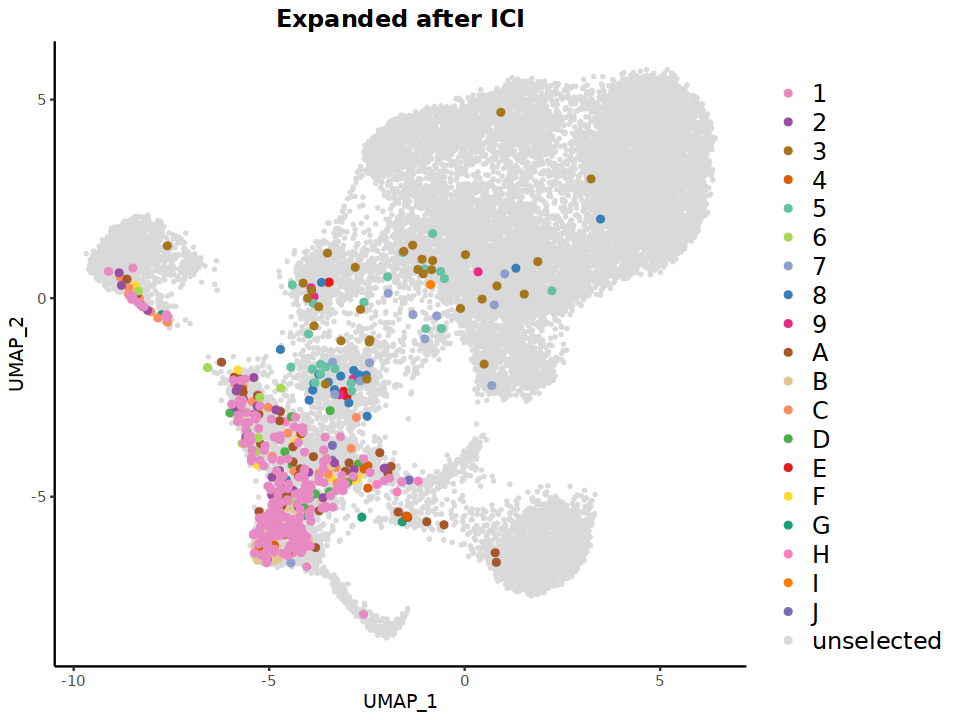

In [18]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)

plt <- umap_plot(df_plot, color_tops,"Expanded after ICI") 
plt

In [19]:
list_plots <- list(plt)

In [20]:
legend <- get_legend(
  plt + theme(legend.box.margin = margin(12,12, 12, 12))
)

In [21]:
list_plots_2 <- lapply(unique(df_plot$timepoint), function(tp) {
    umap_plot(df_plot[df_plot$timepoint == tp,], color_tops, tp) + NoLegend()
    })

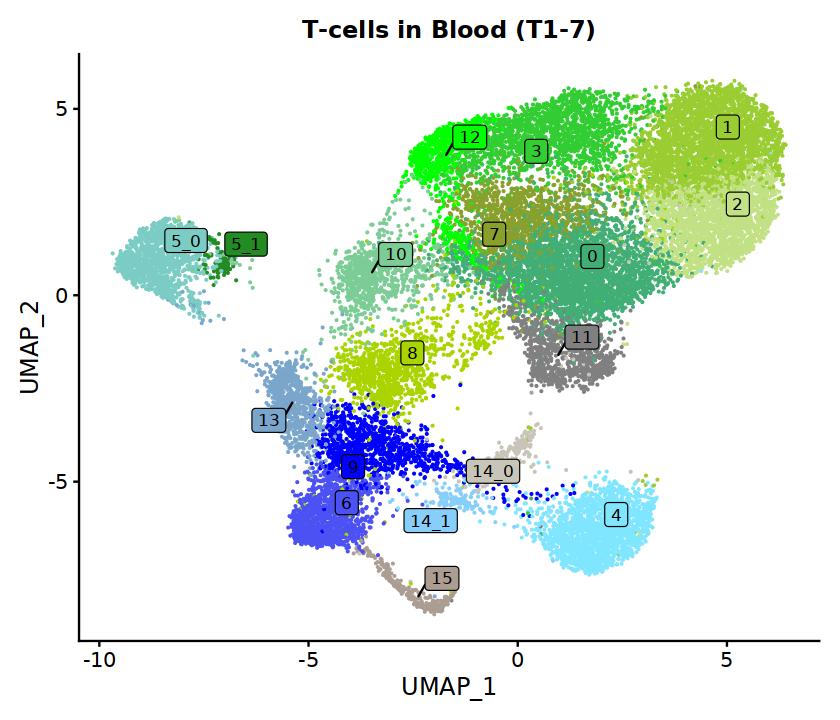

In [22]:
options(repr.plot.width = 7, repr.plot.height = 6, warn=-1,verbose = FALSE)
clust_p <- DimPlot(
  pbmc_obj,
  reduction = "umap",
 label = T,
  label.box = TRUE,
  label.size = 3.5,
  repel = TRUE,
  cols = unlist(pbmc_pal),
  pt.size = 0.1
) + NoLegend() + ggtitle('T-cells in Blood (T1-7)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 14, face = "bold"))
clust_p

In [23]:
list_plots_2 <- c(list(clust_p), list_plots_2)

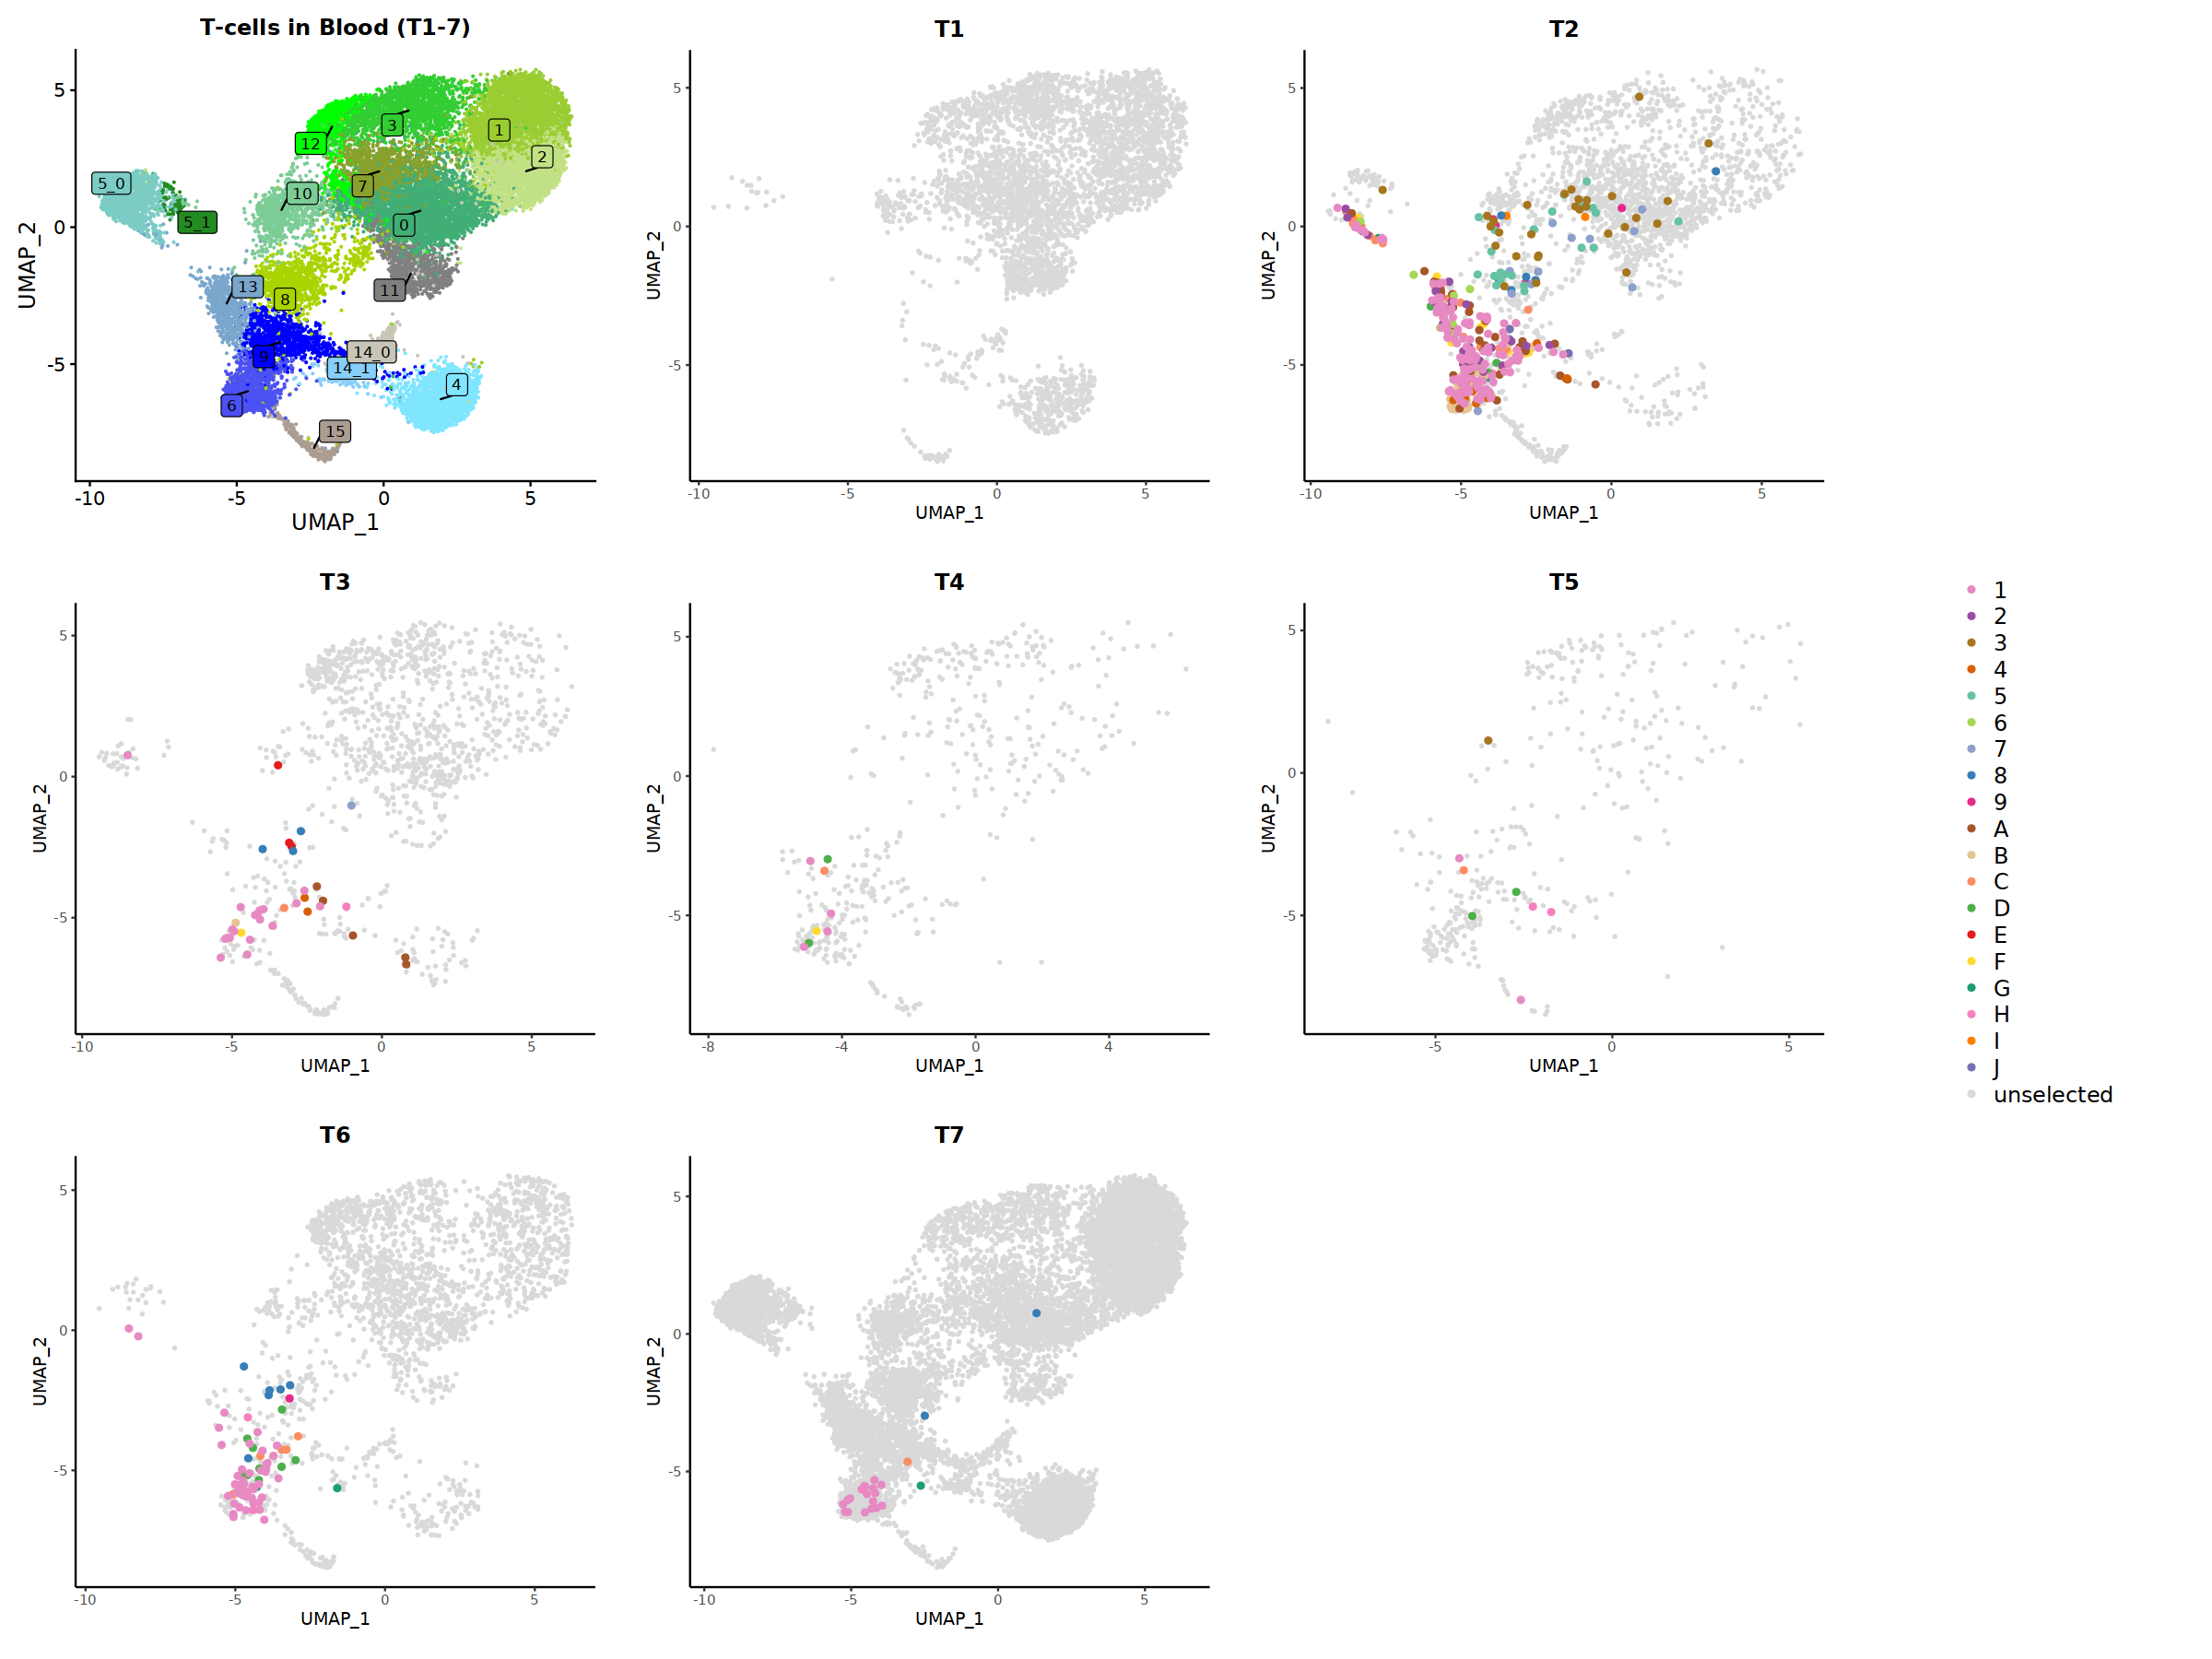

In [24]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
cp1 <- plot_grid(plotlist = list_plots_2,
                   align = "hv",
                   axis = "trbl",
                   ncol = 3,
                   nrow = 3)
cp <- plot_grid(cp1, legend,rel_widths = c(1, .2))
cp

In [25]:
save_plot(plot = cp, filename=here(glue("{tcr}/{plt_dir}/5.2-umap_timepoints.svg")),
          base_width=20, base_height=15)

### Barplot phenotypes

**Clonotypes as X variable**

In [26]:
df_plot <- pbmc_obj@meta.data %>% 
    dplyr::filter(!is.na(ranking)) %>% 
    group_by(cdr3,ranking,Tcell_clusters) %>%
    summarise(
        timepoint = list(unique(timepoint)),
        count = n()
  ) %>% arrange(desc(count))
df_plot 

`summarise()` has grouped output by 'cdr3', 'ranking'. You can override using the `.groups` argument.


cdr3,ranking,Tcell_clusters,timepoint,count
<chr>,<chr>,<fct>,<list>,<int>
GCCACCAGTGAGGCAGGGAATGTGCAGTAC,1,6,"T2, T3, T4, T6, T7",120
GCCAGCAGTTTCGGGGCTTCAGACACTGAAGCTTTC,B,6,"T2, T3",42
GCCACCAGTGAGGCAGGGAATGTGCAGTAC,1,13,"T2, T4, T5, T6",40
GCCACCAGTGAGGCAGGGAATGTGCAGTAC,1,9,"T2, T3, T6",37
AGTGCTAGAGCTTATCGGACAGGGGGCAATGAGCAGTTC,A,9,"T2, T3",13
AGTGCTAGAGCTTATCGGACAGGGGGCAATGAGCAGTTC,A,13,T2,12
GCCAGCAGCCCGCTTCACTATGGCTACACC,8,8,"T2, T3, T6, T7",12
GCCAGCAGCTTGAAACAGGCCCATAATTCACCCCTCCAC,C,9,"T2, T3, T4, T5, T6, T7",12
GCCAGCAGTCTAGGGGCTAGCACAGATACGCAGTAT,5,8,T2,11


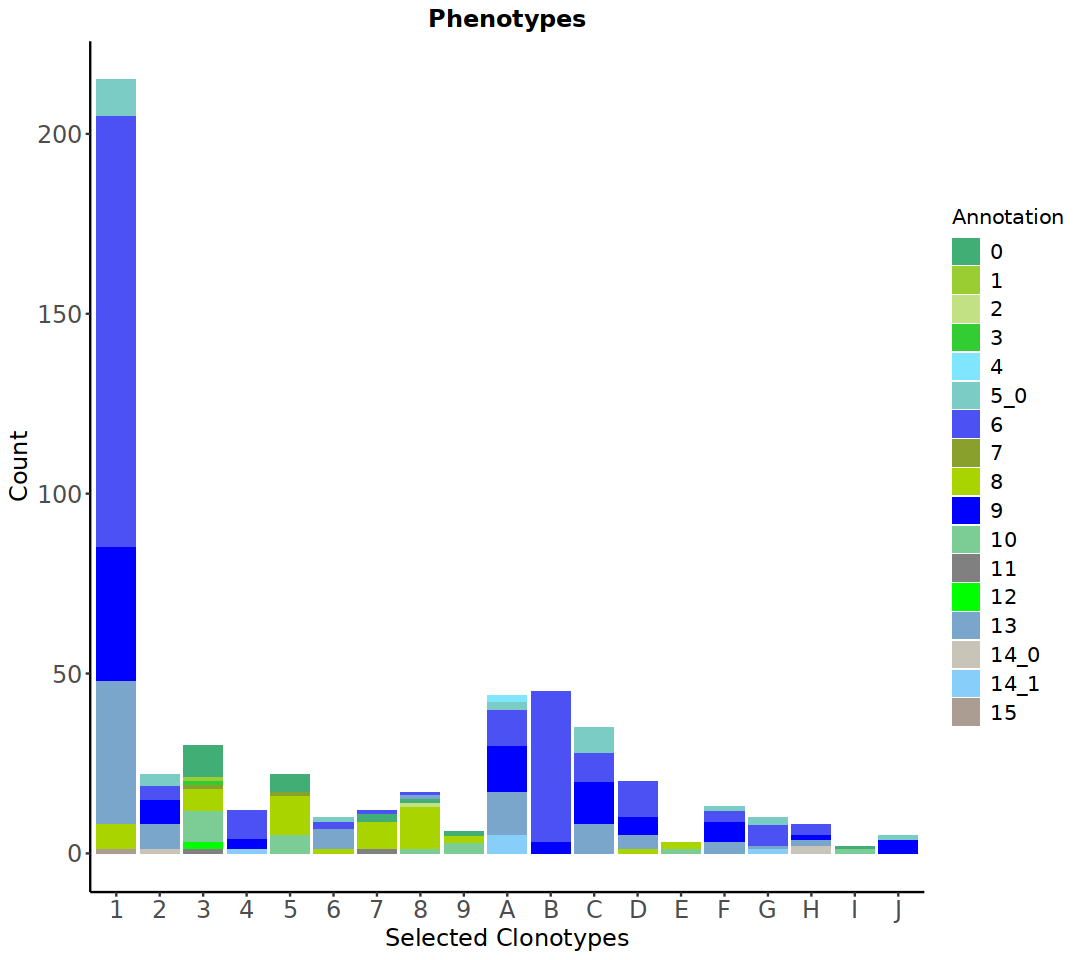

In [27]:
options(repr.plot.width = 9, repr.plot.height = 8, warn=-1,verbose = FALSE)

plt <- ggplot(df_plot, aes(x = ranking, y = count, fill = Tcell_clusters)) +
  geom_bar(stat = "identity") +
  labs(title = "Phenotypes",
       x = "Selected Clonotypes",
       y = "Count") +
       scale_fill_manual(breaks = names(pbmc_pal),
                             values = unname(pbmc_pal)) + 
  theme_classic() + 
  theme(plot.title = element_text(hjust = 0.5, face="bold", size=14),
        axis.text.x = element_text(size = 14),  
        axis.text.y = element_text(size = 14),
        text = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title=element_text(size=12)) + 
 guides(fill = guide_legend(title = "Annotation", ncol = 1))

plt

In [28]:
list_plots <- c(list_plots,list(plt))

In [29]:
legend <- get_legend(
  plt + theme(legend.box.margin = margin(12,12, 12, 12))
)

In [30]:
pbmc_obj@meta.data$ranking <- as.factor(pbmc_obj@meta.data$ranking)

In [31]:
options(repr.plot.width = 16, repr.plot.height = 6, warn=-1,verbose = FALSE)
list_plots_2 <- lapply(c("T2", "T3", "T4", "T5", "T6", "T7"), function(tp) {
    
    df_plot <- pbmc_obj@meta.data %>% 
        dplyr::filter(!is.na(ranking)) %>% 
        dplyr::filter(timepoint == tp) %>% 
        group_by(cdr3,ranking,Tcell_clusters) %>%
        summarise(
        count = n()
  ) %>% arrange(desc(count))
    
   ggplot(df_plot, aes(x = ranking, y = count, fill = Tcell_clusters)) +
      geom_bar(stat = "identity") +
      labs(title = tp,
           x = "ranking",
           y = "count") +
      scale_x_discrete(drop=FALSE) +
      scale_fill_manual(breaks = names(pbmc_pal),
                                 values = unname(pbmc_pal)) +
      theme_classic() + 
      theme(plot.title = element_text(hjust = 0.5),
            axis.text.x = element_text(size = 14),  
            axis.text.y = element_text(size = 14),
            text = element_text(size = 16),
            legend.text = element_text(size = 10)) +
      NoLegend()
})
cp1 <- plot_grid(plotlist = list_plots_2,
                   align = "hv",
                   axis = "trbl",
                   ncol = 4,
                   nrow = 2)

`summarise()` has grouped output by 'cdr3', 'ranking'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cdr3', 'ranking'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cdr3', 'ranking'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cdr3', 'ranking'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cdr3', 'ranking'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cdr3', 'ranking'. You can override using the `.groups` argument.


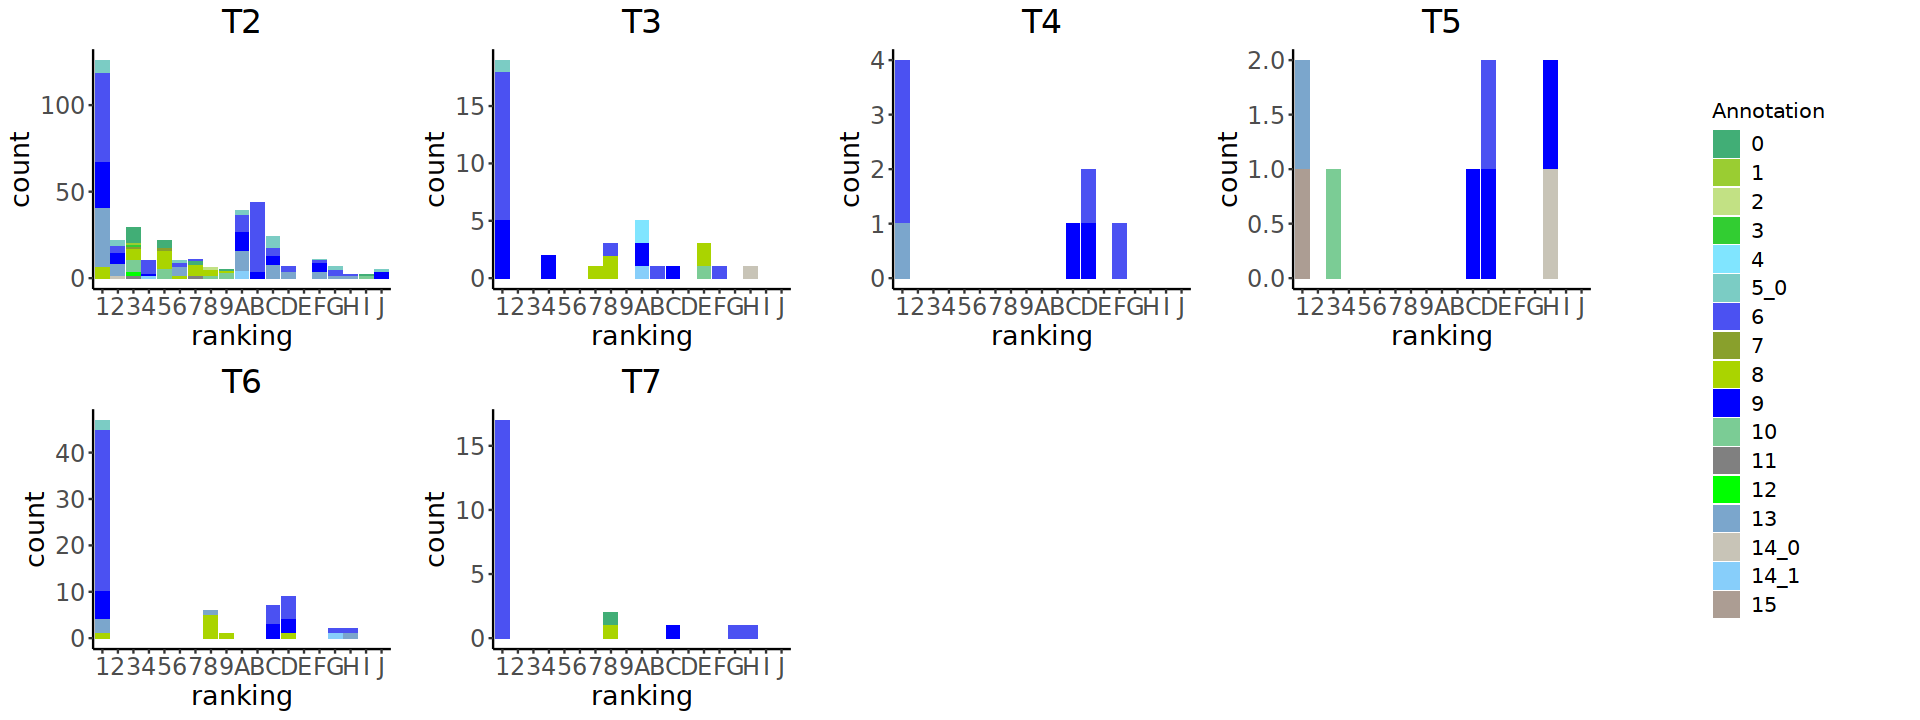

In [32]:
options(repr.plot.width = 16, repr.plot.height = 6, warn=-1,verbose = FALSE)
cp <- plot_grid(cp1, legend,rel_widths = c(1, .2))
cp

In [33]:
cowplot::save_plot(plot = cp, filename=here(glue("{tcr}/{plt_dir}/5.2-barplot_timepoints.svg")),
          base_width=12, base_height=10)

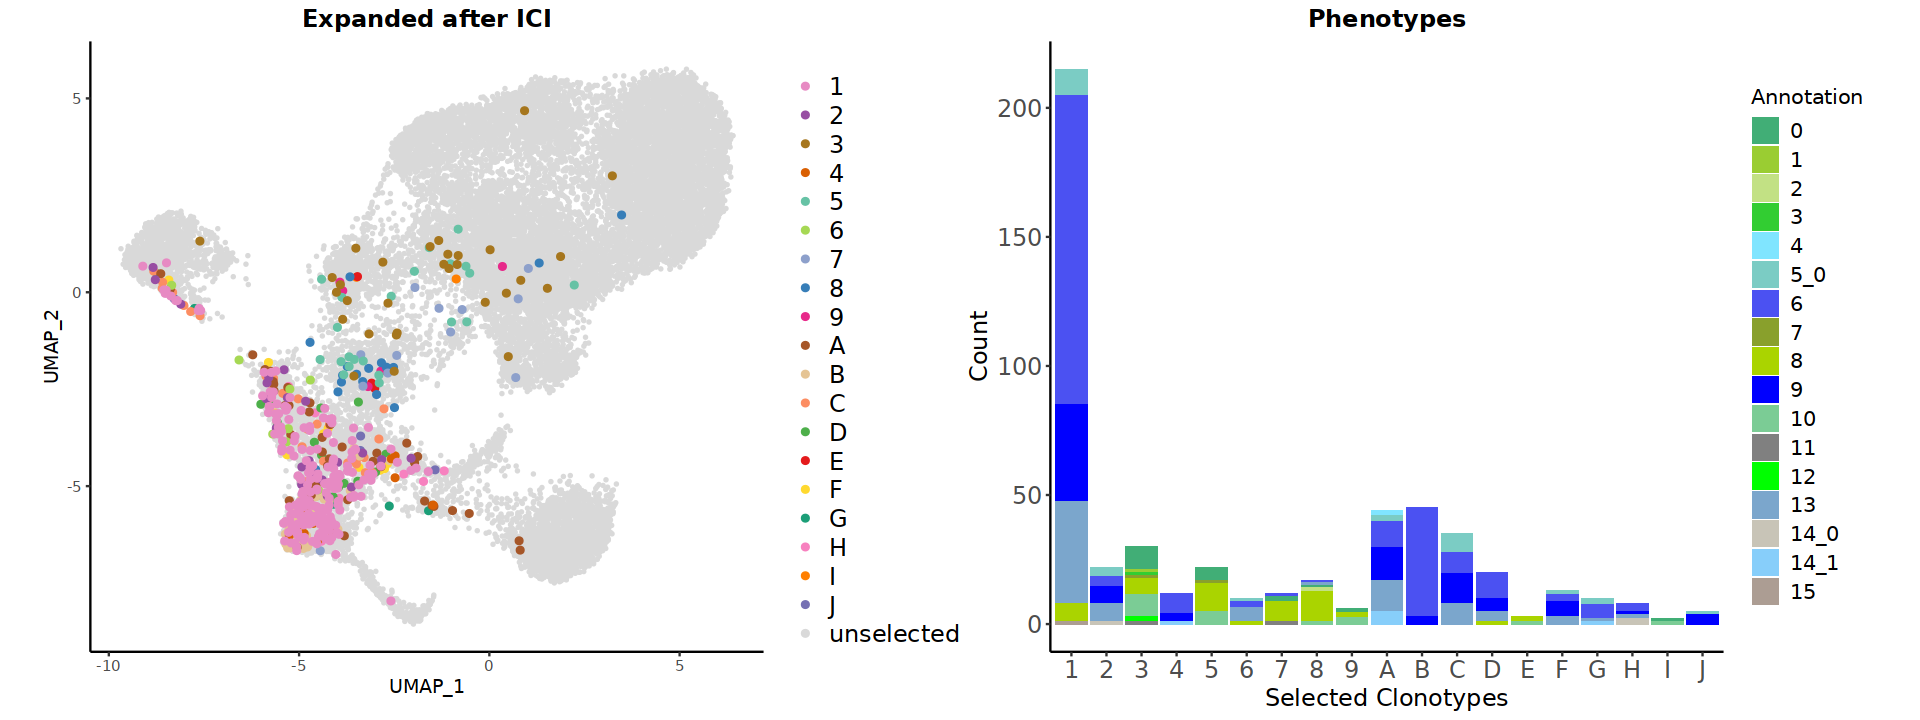

In [34]:
options(repr.plot.width = 16, repr.plot.height = 6, warn=-1,verbose = FALSE)
cp <- plot_grid(plotlist = list_plots[c(1,2)],
                   align = "hv",
                   axis = "trbl",
                   ncol = 2,
                   nrow = 1)
cp

In [35]:
cowplot::save_plot(plot = cp, filename=here(glue("{tcr}/{plt_dir}/5.2-clonotype_dynamics.svg")),
          base_width=20, base_height=5)

In [36]:
write.csv(pbmc_obj@meta.data, here(glue("{tcr}/{robj_dir}/5.2-metadata.csv")))

## Tumor

In [37]:
df_meta <- tumor_obj@meta.data %>%
  rownames_to_column("Barcode")

df_meta <- left_join(df_meta, all_tcr, by="cdr3")

tumor_obj@meta.data$ranking <- df_meta$ranking

In [38]:
tumor_obj@meta.data$ranking <- df_meta$ranking

In [39]:
df_meta %>%
    dplyr::filter(!is.na(ranking))

Barcode,orig.ident,nCount_RNA,nFeature_RNA,sample_org,timepoint,replicate,sample_id,pct_mt,percent.ribo,⋯,CTnt,CTaa,CTstrict,Frequency,cloneType,cdr3,counts_t1,counts_t2_3,ranking,deepTCR
<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<int>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<chr>


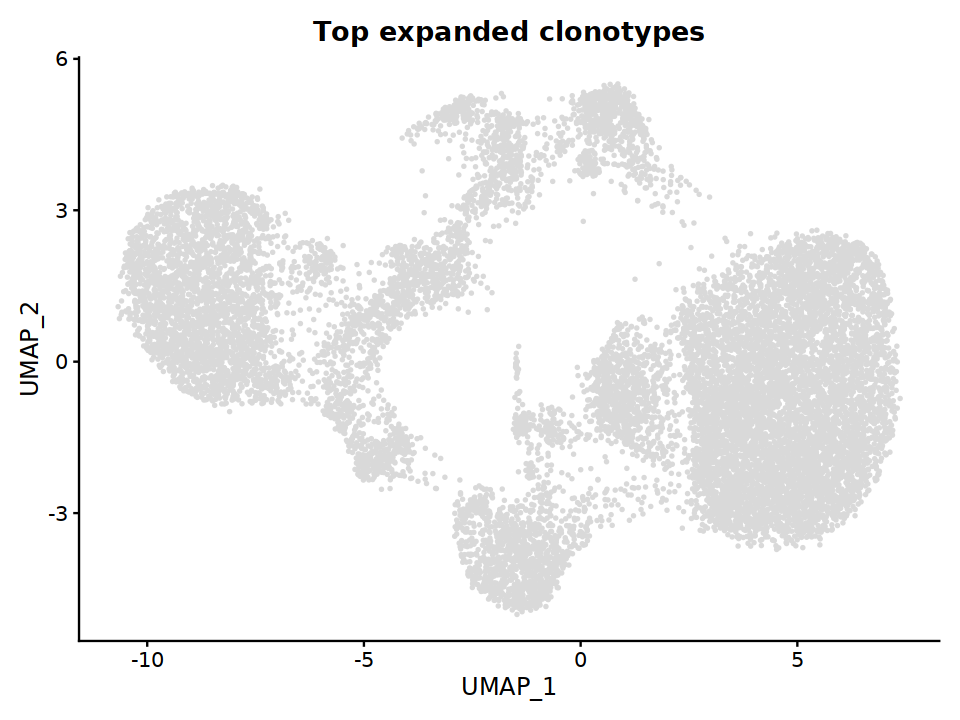

In [40]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(tumor_obj, group.by = "ranking", cols="red",cols.highlight="red",
               na.value="#d9d9d9", pt.size = 0.5) + 
    ggtitle(glue('Top expanded clonotypes')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),)

None of those found in the TME

# Session Info

In [41]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1       lubridate_1.9.3     forcats_1.0.0      
 [4] stringr_1.5.0       dplyr_1.1.3         purrr_1.0.2        
 [7] readr_2.1.4         tidyr_1.3.0         tibble_3.2.1       
[10] tidyverse_2.0.0     glue_1.6.2          here_1.0.1         
[13] scRepertoire_1.1